In [1]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
from skimage import measure, morphology
import matplotlib.pyplot as plt

from loader import data_loader

#package to read .png files
from PIL import Image
import os 
from skimage.morphology import skeletonize
from graph_plotting import graph_2D


In [3]:


#gen_void_graph = data_loader.VoidGraphGenerator("/media/data/alex_johannes/octa_data/segs", "/media/data/alex_johannes/octa_data/void_graphs")
#gen_void_graph.save_region_graphs()

In [2]:
seg = Image.open(os.path.join("/media/data/alex_johannes/octa_data/segs", "pred_10301.png"))
seg = np.array(seg)
seg = seg.astype(np.uint8)

/tmp/ipykernel_18315/2452019217.py:5: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  skeleton = skeletonize(morphology.remove_small_holes(seg, area_threshold=9, connectivity=1).astype("uint8"))


uint8


/tmp/ipykernel_18315/2452019217.py:17: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  region_labels = measure.label(morphology.remove_small_holes(seg, area_threshold=9, connectivity=1).astype("uint8"), background=1)


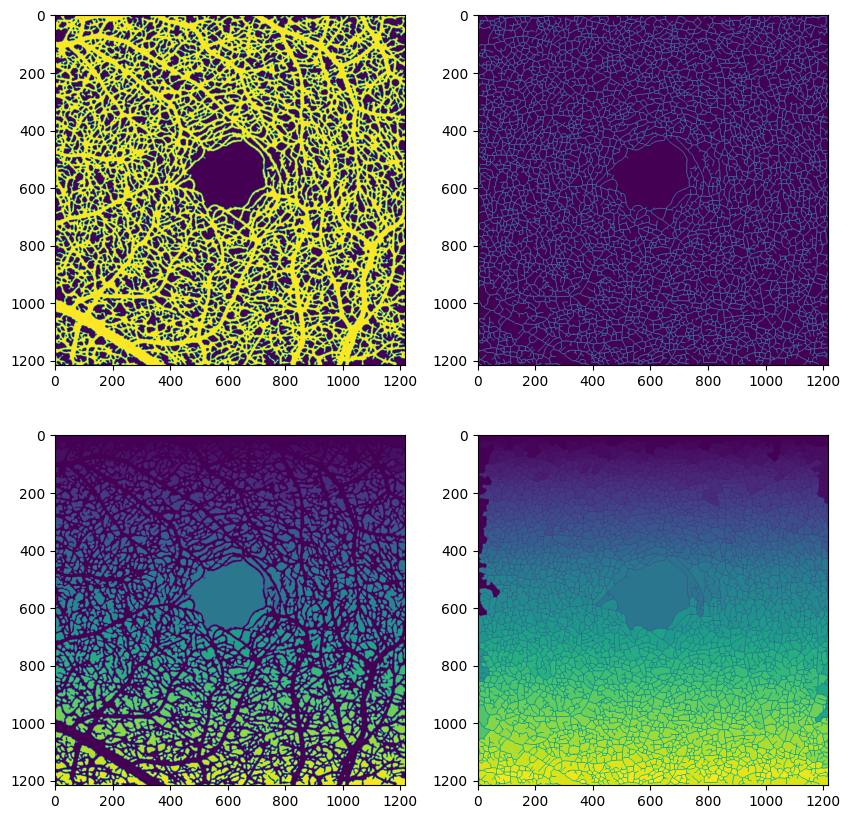

In [3]:


fig, ax = plt.subplots(2,2, figsize=(10,10))
seg = np.array(seg)
seg = seg.astype(np.uint8)

skeleton = skeletonize(morphology.remove_small_holes(seg, area_threshold=9, connectivity=1).astype("uint8"))
skeleton = skeletonize(seg)
skeleton = skeleton.astype(np.uint8)

print(skeleton.dtype)

ax[0,0].imshow(seg)
ax[0,1].imshow(skeleton)

# regions should stay the same even after skeletonization

seg_labeled = measure.label(seg, background=255)
region_labels = measure.label(morphology.remove_small_holes(seg, area_threshold=9, connectivity=1).astype("uint8"), background=1)

skel_labeled = measure.label(skeleton, background=1, connectivity=1)

ax[1,0].imshow(region_labels)
ax[1,1].imshow(skel_labeled)

plt.show()



In [ ]:
vessel_graph_loader_2_cls = data_loader.VesselLoaderTorch("/media/data/alex_johannes/octa_data/graphs", "/media/data/alex_johannes/octa_data/labels.xlsx", two_cls= True, create_line= True)
void_graph_loader_2_cls = data_loader.VesselLoaderTorch("/media/data/alex_johannes/octa_data/void_graphs", "/media/data/alex_johannes/octa_data/labels.xlsx", two_cls= True, create_line= False)


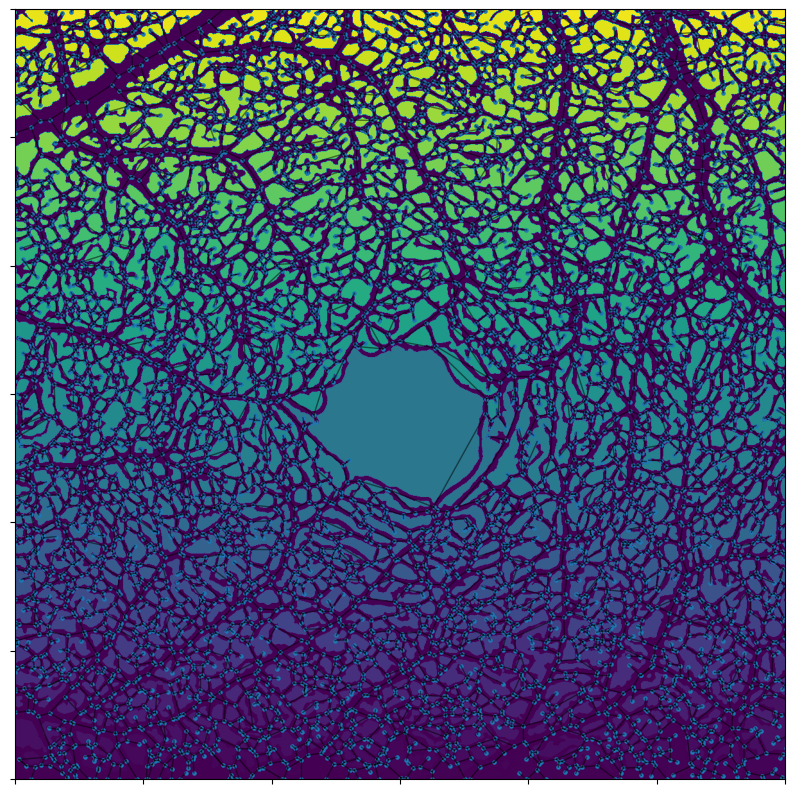

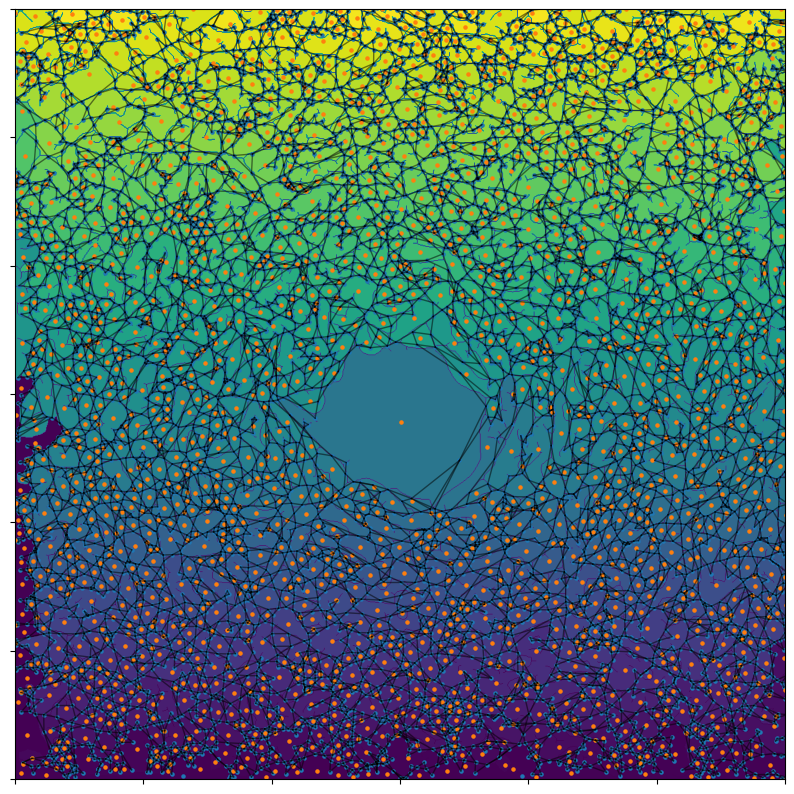

In [87]:

#fig, ax = plt.subplots(1,2, figsize=(10,5))
#
#
## vessel and void have same orientation, but seem to be  hoizontally flipped compared to the seg
#graph_2D.GraphPlotter2D(vessel_graph_loader_2_cls.full_data[10301]).plot_graph_2D(ax = ax[0])
#graph_2D.GraphPlotter2D(void_graph_loader_2_cls.full_data[10301]).plot_graph_2D(ax = ax[1])
#plt.show()

fig, ax = plt.subplots(figsize=(10,10))

# vessel and void have same orientation, but seem to be  hoizontally flipped compared to the seg
graph_2D.GraphPlotter2D(vessel_graph_loader_2_cls.full_data[10301]).plot_graph_2D(ax = ax)
ax.imshow(region_labels)
plt.show()

fig, ax = plt.subplots(figsize=(10,10))

# vessel and void have same orientation, but seem to be  hoizontally flipped compared to the seg
ax.imshow(skel_labeled)
graph_2D.GraphPlotter2D(vessel_graph_loader_2_cls.line_data[10301], line_G= True).plot_graph_2D(edges = True, ax = ax)
graph_2D.GraphPlotter2D(void_graph_loader_2_cls.full_data[10301]).plot_graph_2D(edges = False, ax = ax)

plt.show()


Data(edge_index=[2, 4], num_nodes=3, pos=[3, 2])


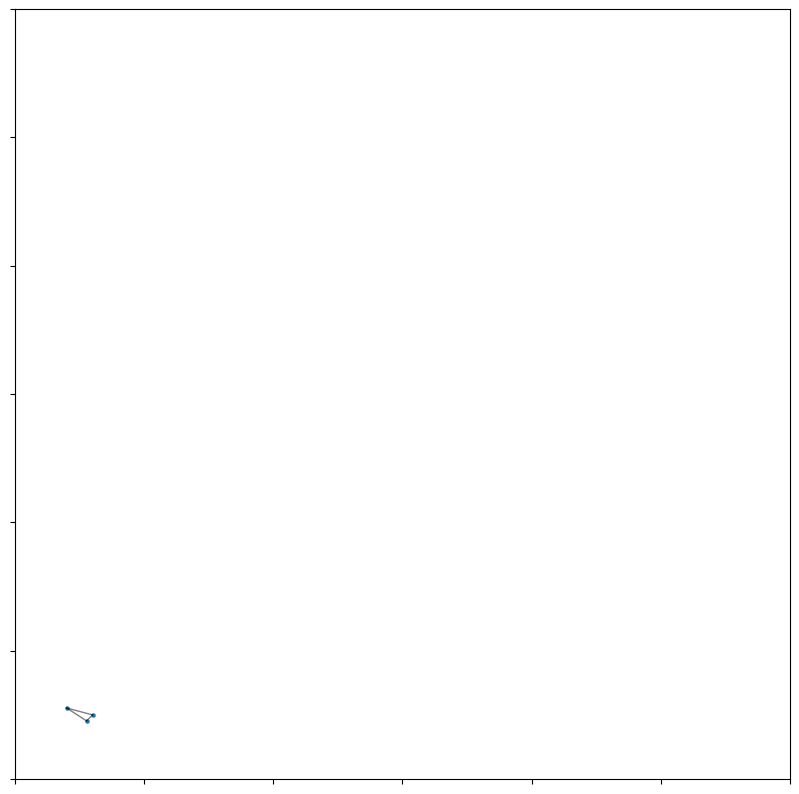

True

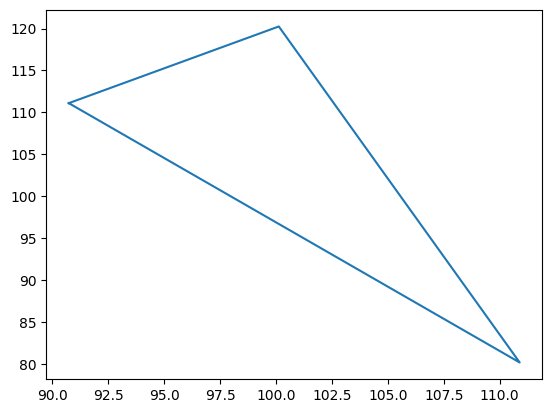

In [84]:
# add the 50 nearest nodes by position from a given start position

# add the 50 nearest nodes by position from a given start position
import torch
from torch_geometric.utils import subgraph
from torch_geometric.data import Data

def find_nearest_nodes(pytroch_geom_data, start_pos, n_nodes = 50):
    """
    Returns the indices of the n_nodes nearest nodes to the start_pos
    """
    dists = torch.norm(pytroch_geom_data.pos - np.array(start_pos), dim = 1)
    return torch.argsort(dists)[:n_nodes]

nodes = find_nearest_nodes(void_graph_loader_2_cls.full_data[10301], [100,100])

# check for an increasing number of included points, if they induce a cycle in the graph
def check_cycle(nodes, edge_index):
    for i in range(3, len(nodes)):
        # check if the subgraph induced by the first i nodes is a cycle
        subg_idx, _ = subgraph(nodes[:i], edge_index, relabel_nodes= True)

        subg = Data(edge_index = subg_idx, num_nodes = len(nodes[:i]))
        # check if the subgraph is a cycle
        if has_cycle(subg):
            # find the nodes in the subgraph that induce the cycle

            




            #return nodes[:i], subg
    return False


# check for an increasing number of included points, if they induce a simple cycle in the graph
def has_cycle(data):

    num_nodes = data.num_nodes
    visited = torch.zeros(num_nodes, dtype=torch.bool)
    parent = torch.zeros(num_nodes, dtype=torch.long) - 1  # Initialize parent as -1

    def dfs(node):
        visited[node] = True

        for neighbor in data.edge_index[0][data.edge_index[1] == node]:
            if not visited[neighbor]:
                parent[neighbor] = node
                if dfs(neighbor):
                    return True
            elif parent[node] != neighbor:
                return True
        return False

    for start_node in range(num_nodes):
        if not visited[start_node]:
            if dfs(start_node):
                return True

    return False

nodes, subg = check_cycle(nodes, void_graph_loader_2_cls.full_data[10301].edge_index)
subg.pos = void_graph_loader_2_cls.full_data[10301].pos[nodes]

print(subg)
fig, ax = plt.subplots(figsize=(10,10))

graph_2D.GraphPlotter2D(subg).plot_graph_2D(ax = ax)
plt.show()


# import polygon

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# check if a node is inside a region, the region is defined by a polygon created from nodepositions
def check_inside(node_list, start_pos):
    """
    returns true if the start_pos is inside the polygon defined by the node_list
    """
    # create a polygon from the node positions
    poly = Polygon(node_list)
    # create a point from the start_pos
    point = Point(start_pos)
    # check if the point is inside the polygon

    return poly.contains(point)



check_inside(void_graph_loader_2_cls.full_data[10301].pos[nodes], [100,100])

In [9]:
vessel_graph_loader_2_cls.full_data[10301].edge_index

tensor([[ 858,  861,  859,  ..., 6089, 6090, 6090],
        [  21,   31,   33,  ...,  816,  844,  845]])

In [ ]:
octa500_loader_2_cls = data_loader.VesselLoaderTorch("/media/data/alex_johannes/octa_data/graphs", "/media/data/alex_johannes/octa_data/labels.xlsx", two_cls= True)


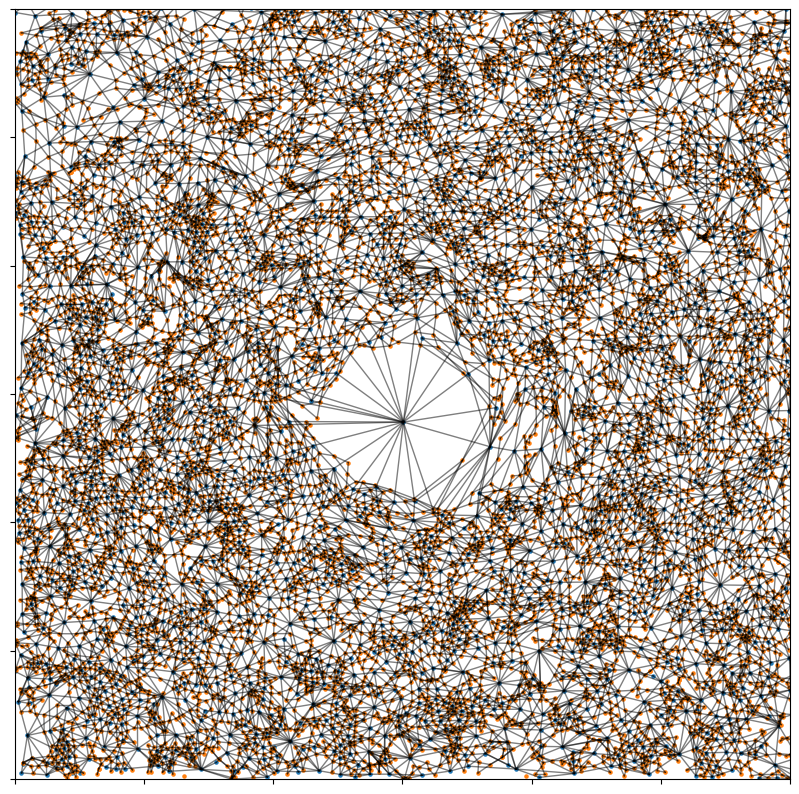

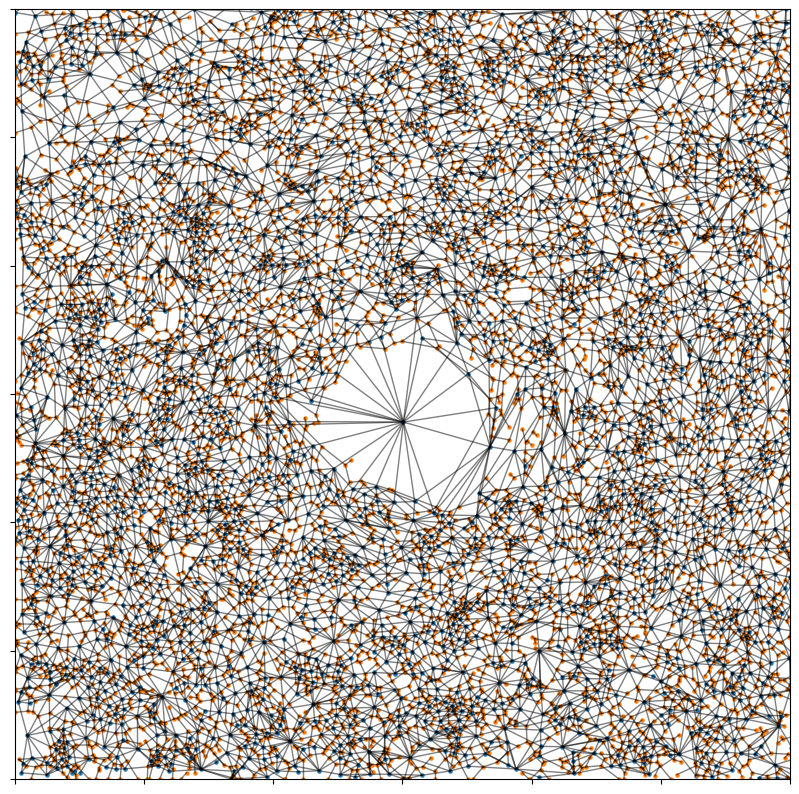

In [19]:

fig, ax = plt.subplots(figsize=(10,10))
# two points in the center because one region is the background(vessel)

# this is the line graph
graph_2D.GraphPlotter2D(void_graph_loader_2_cls.region_graphs[10301]).plot_graph_2D(ax = ax)
graph_2D.GraphPlotter2D(octa500_loader_2_cls.line_data[10301], line_G = True).plot_graph_2D(ax = ax)
plt.show()


fig, ax = plt.subplots(figsize=(10,10))
# two points in the center because one region is the background(vessel)

# this is the regular graph
graph_2D.GraphPlotter2D(void_graph_loader_2_cls.region_graphs[10301]).plot_graph_2D(ax = ax)
graph_2D.GraphPlotter2D(octa500_loader_2_cls.full_data[10301]).plot_graph_2D(ax = ax)
plt.show()

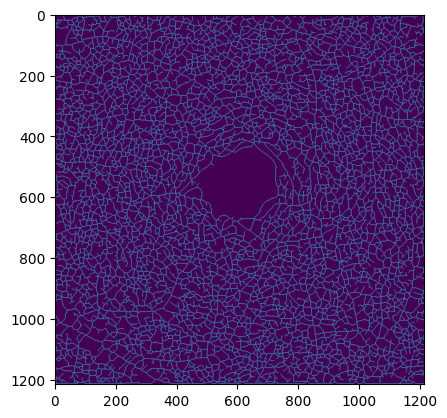

2723


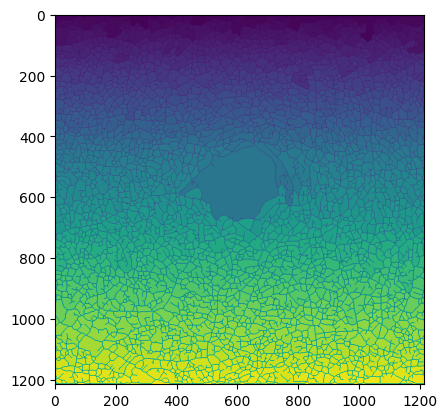

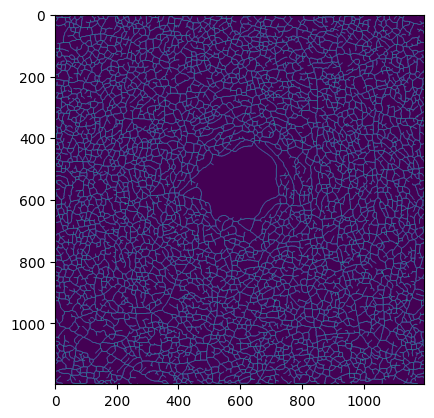

2527


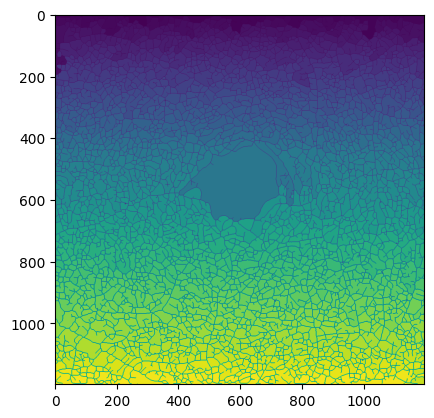

In [ ]:
crop_val = 9

skeleton_alt = skeletonize(seg[crop_val:-crop_val, crop_val:-crop_val])


seg_work = seg.copy()
# make all border pixels 1
seg_work[0,:] = 255
seg_work[-1,:] = 255
seg_work[:,0] = 255
seg_work[:,-1] = 255

skeleton_border = skeletonize(seg_work)

plt.imshow(skeleton_border==1)
plt.show()


skel_labeled = measure.label(skeleton_border, background=1, connectivity=1)

print(len(np.unique(skel_labeled)))
plt.imshow(skel_labeled)
plt.show()



plt.imshow(skeleton_alt==1)
plt.show()

skeleton_alt = skeleton_alt.astype(np.uint8)

# regions should stay the same even after skeletonization

skel_labeled = measure.label(skeleton_alt, background=1, connectivity=1)

print(len(np.unique(skel_labeled)))

plt.imshow(skel_labeled)
plt.show()